# Image Processing with NumPy

This notebook explores fundamental image-processing techniques using NumPy and SciPy. Topics:
- **2D FFT** — visualise the frequency content hidden inside images
- **Frequency-domain filters** — low-pass (blur), high-pass, and band-pass using FFT masks
- **Spatial-domain Gaussian blur** — convolution with a Gaussian kernel
- **Noise & denoising** — Gaussian and salt-and-pepper noise; Gaussian, median, and mean filters
- **Edge detection** — image derivatives via `np.gradient`, Sobel, Prewitt, and Laplacian operators

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

try:
    from ipywidgets import interact, FloatSlider, IntSlider, Dropdown, Checkbox
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False
    print('ipywidgets not available. Install with: pip install ipywidgets')

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['image.interpolation'] = 'nearest'

## 1. Test Images

We use a mix of **synthetic** images (built with NumPy) and **real** classic benchmarks
loaded from [scikit-image](https://scikit-image.org/):

| Image | Source | Purpose |
|---|---|---|
| Checkerboard | Synthetic | Sharp high-frequency edges on a grid |
| Concentric Rings | Synthetic | Radially symmetric oscillation |
| Sinusoidal Gradient | Synthetic | Smooth 2-D sine/cosine pattern |
| Scene | Synthetic | Mixed: gradient, hard edges, circle, fine texture |
| **Cameraman** | scikit-image | Classic 512×512 grayscale benchmark |
| **Lena / Astronaut** | scikit-image | Classic portrait benchmark (Lena removed in skimage ≥ 0.19) |

In [2]:
SIZE = 256  # all images are SIZE x SIZE

def make_checkerboard(size=SIZE, squares=8):
    """Sharp checkerboard pattern — lots of high-frequency content."""
    r, c = np.mgrid[:size, :size]
    block = size // squares
    return ((r // block + c // block) % 2).astype(float)

def make_circles(size=SIZE):
    """Concentric rings — radially symmetric frequency content."""
    cy, cx = size // 2, size // 2
    y, x = np.ogrid[:size, :size]
    r = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)
    return (np.sin(r * 0.25) + 1) / 2

def make_gradient(size=SIZE):
    """Smooth 2-D sinusoidal gradient."""
    x = np.linspace(0, 3 * np.pi, size)
    y = np.linspace(0, 2 * np.pi, size)
    xx, yy = np.meshgrid(x, y)
    return (np.sin(xx) * np.cos(yy) + 1) / 2

def make_scene(size=SIZE):
    """Synthetic scene with mixed spatial frequencies."""
    img = np.zeros((size, size))
    # Smooth gradient background (left → right)
    img += np.linspace(0, 0.4, size)[np.newaxis, :]
    # Hard-edged bright rectangle
    img[55:105, 55:130] = 0.9
    # Filled circle
    cy, cx = 175, 180
    y, x = np.ogrid[:size, :size]
    img[(x - cx) ** 2 + (y - cy) ** 2 <= 55 ** 2] = 0.75
    # Fine texture patch
    n_rows, n_cols = 65, 80
    ty = np.linspace(0, 10 * np.pi, n_cols)
    tx = np.linspace(0, 10 * np.pi, n_rows)
    txg, tyg = np.meshgrid(ty, tx)
    img[15:80, 140:220] += 0.12 * np.sin(txg) * np.sin(tyg)
    return np.clip(img, 0, 1)

TEST_IMAGES = {
    'Checkerboard':       make_checkerboard(),
    'Concentric Rings':   make_circles(),
    'Sinusoidal Gradient': make_gradient(),
    'Scene':              make_scene(),
}

In [3]:
# Load classic example images from scikit-image (added to requirements.txt).
# pip install scikit-image
try:
    from skimage import data as sk_data

    # Cameraman (512×512) — the most-cited grayscale test image
    TEST_IMAGES['Cameraman'] = sk_data.camera().astype(float) / 255.0

    # Lena/Lenna was removed from scikit-image ≥ 0.19 for ethical reasons.
    # We try it first; if unavailable we use 'astronaut' (NASA photo of Eileen Collins)
    # converted to grayscale as a portrait substitute.
    try:
        TEST_IMAGES['Lena'] = sk_data.lena().astype(float) / 255.0
        print('Loaded from scikit-image: Cameraman, Lena')
    except AttributeError:
        TEST_IMAGES['Astronaut (gray)'] = sk_data.astronaut().mean(axis=2) / 255.0
        print('Loaded from scikit-image: Cameraman, Astronaut')
        print('  (Lena removed from scikit-image ≥ 0.19; Astronaut used as portrait substitute)')

except ImportError:
    print('scikit-image not installed — using synthetic images only.')
    print('Run:  pip install scikit-image')

Loaded from scikit-image: Cameraman, Astronaut
  (Lena removed from scikit-image ≥ 0.19; Astronaut used as portrait substitute)


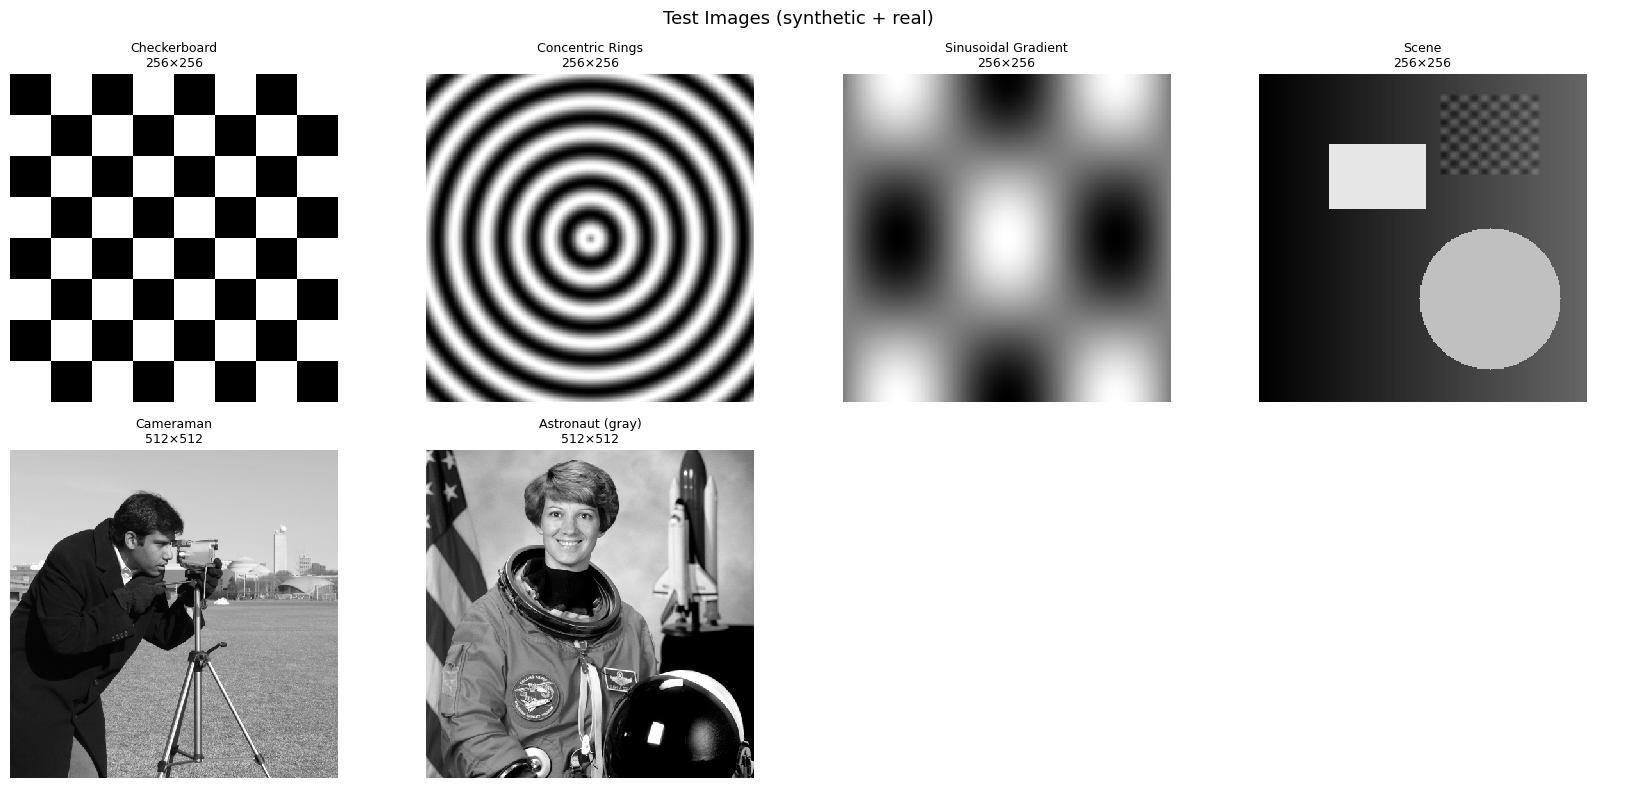

In [4]:
n     = len(TEST_IMAGES)
ncols = min(4, n)
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols,
                         figsize=(4.2 * ncols, 4.0 * nrows),
                         squeeze=False)
axes_flat = axes.flatten()

for ax, (name, img) in zip(axes_flat, TEST_IMAGES.items()):
    ax.imshow(img, cmap='gray', vmin=0, vmax=1)
    ax.set_title(f'{name}\n{img.shape[1]}\u00d7{img.shape[0]}', fontsize=9)
    ax.axis('off')

for ax in axes_flat[n:]:
    ax.axis('off')

plt.suptitle('Test Images (synthetic + real)', fontsize=13)
plt.tight_layout()
plt.show()

## 2. 2-D FFT: Seeing the Frequency Content

The 2-D Discrete Fourier Transform decomposes an image into spatial frequency components:

$$F(u, v) = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x, y)\, e^{-i 2\pi (ux/M + vy/N)}$$

Key functions used:
- `np.fft.fft2(img)` — compute the 2-D FFT
- `np.fft.fftshift(F)` — shift DC (zero frequency) to the centre of the array
- `np.abs(F)` — magnitude spectrum
- `np.log1p(M)` — log scale so faint components are visible
- `np.angle(F)` — phase spectrum

In the shifted magnitude spectrum, the **centre** represents low frequencies (slow variation across the image) and the **edges** represent high frequencies (fine detail).

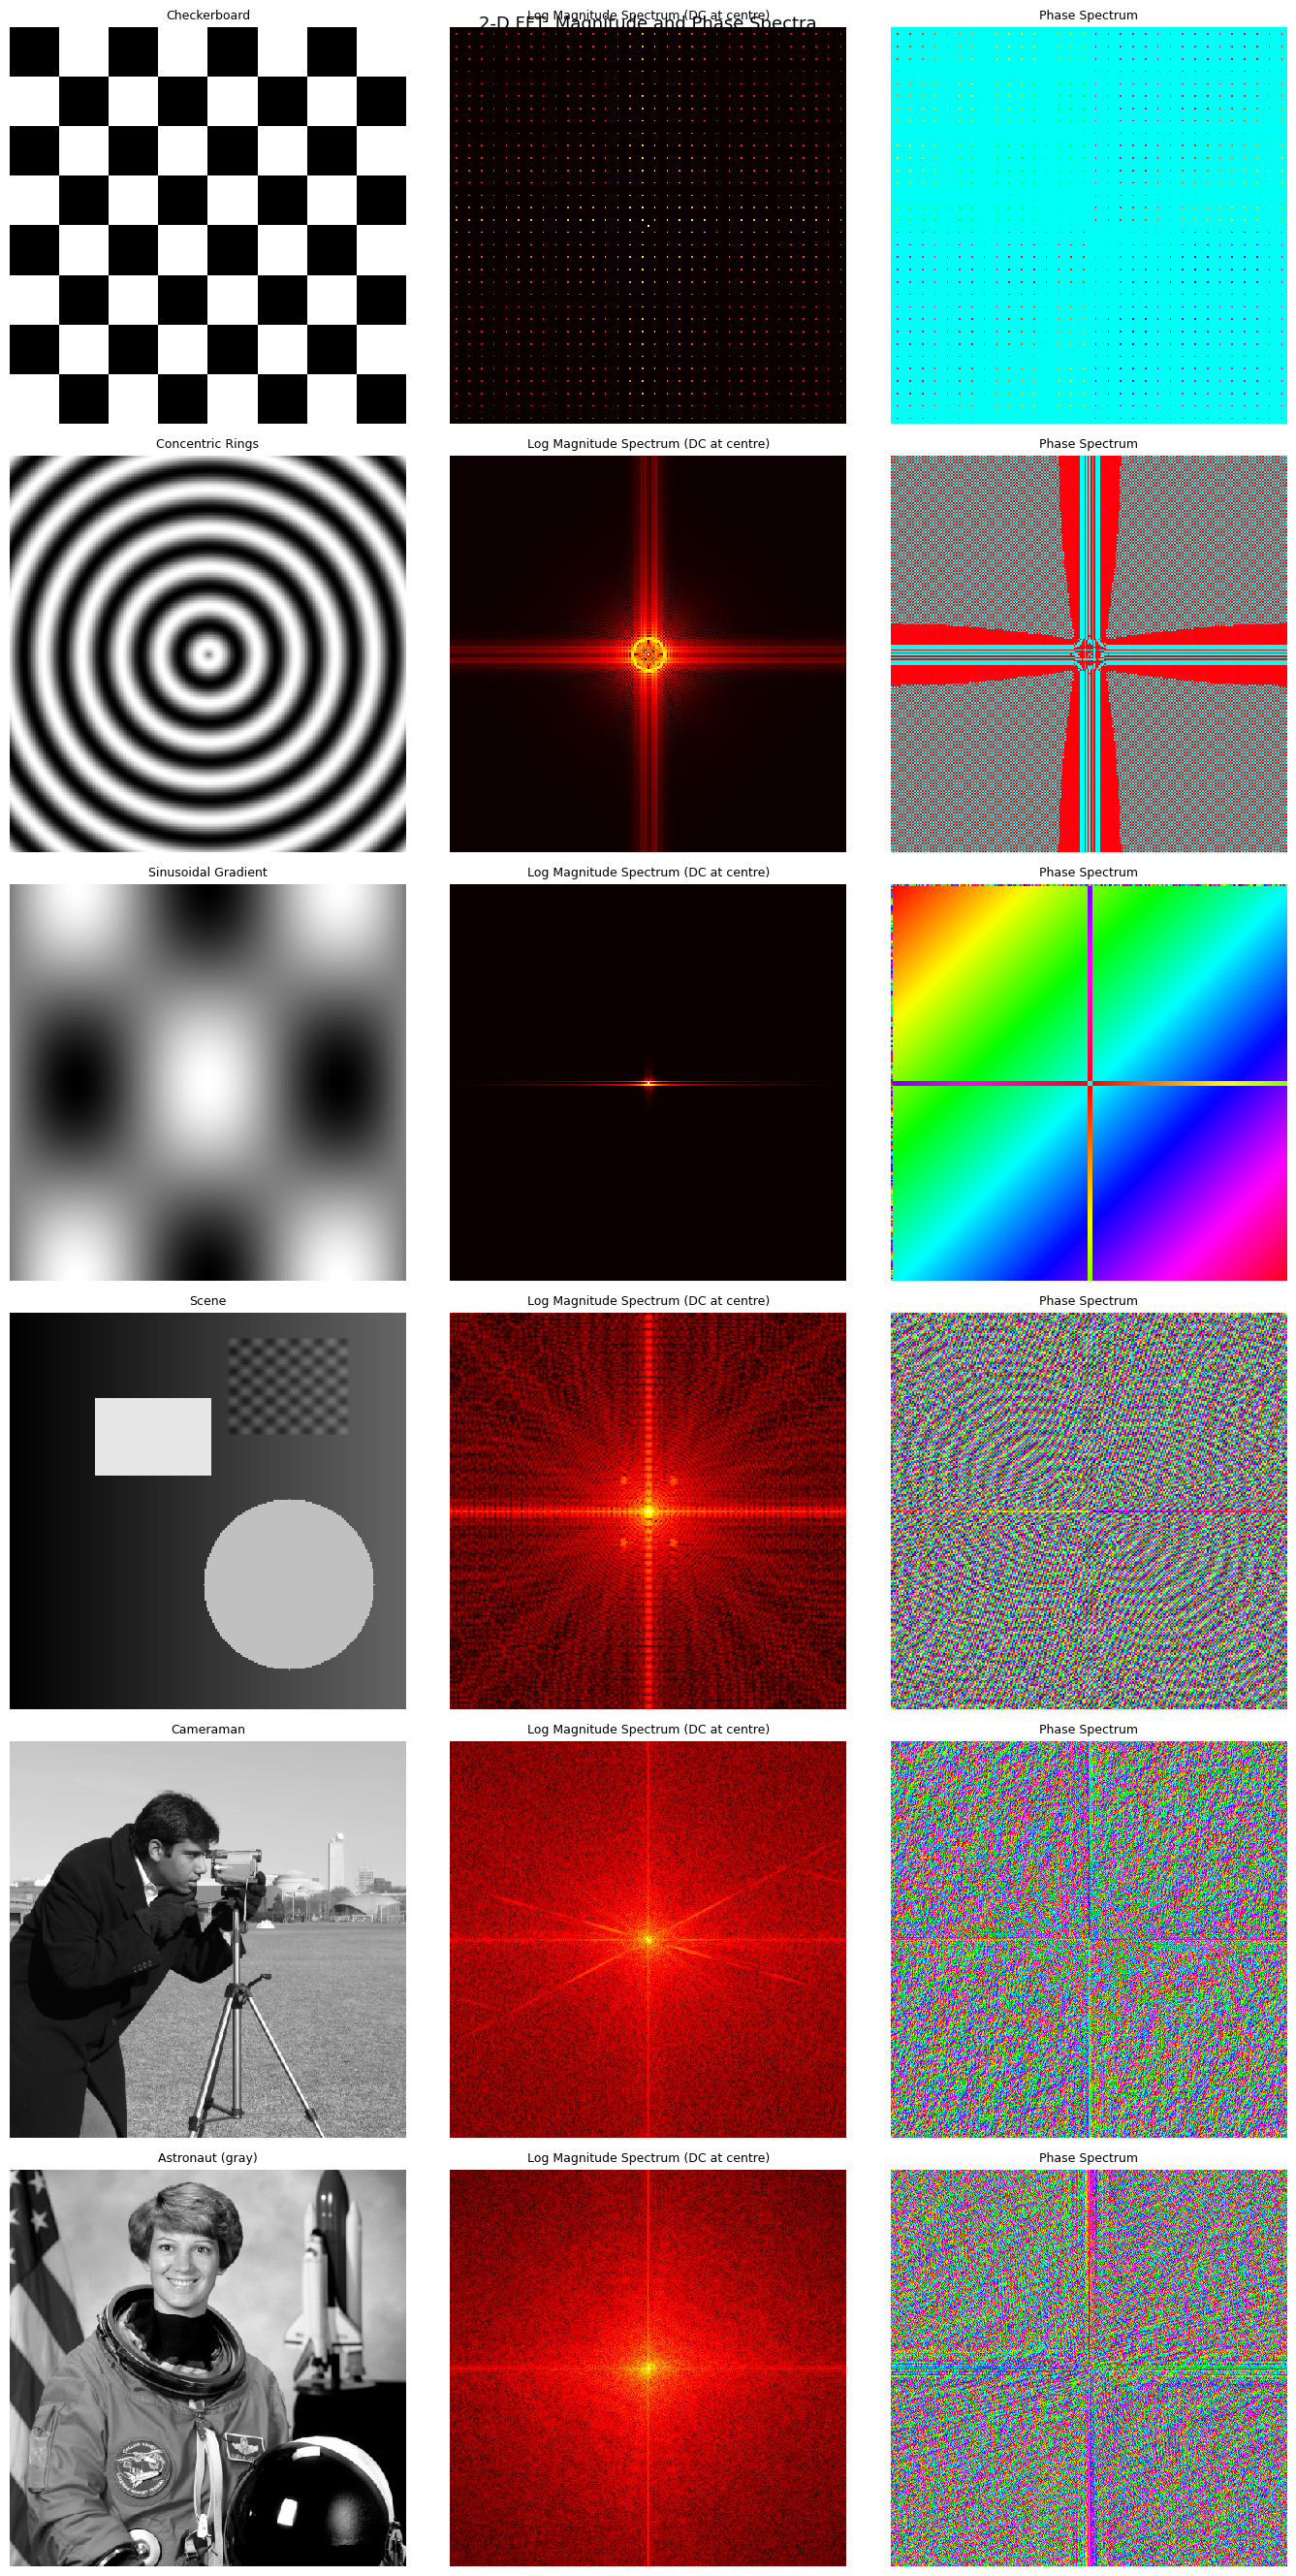

In [5]:
# Static demo: 2-D FFT of every image in TEST_IMAGES
n = len(TEST_IMAGES)
fig, axes = plt.subplots(n, 3, figsize=(14, 4.5 * n), squeeze=False)

for row, (name, img) in enumerate(TEST_IMAGES.items()):
    fft_shifted = np.fft.fftshift(np.fft.fft2(img))
    log_mag = np.log1p(np.abs(fft_shifted))
    phase   = np.angle(fft_shifted)

    axes[row, 0].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[row, 0].set_title(f'{name}', fontsize=9)
    axes[row, 0].axis('off')

    axes[row, 1].imshow(log_mag, cmap='hot')
    axes[row, 1].set_title('Log Magnitude Spectrum (DC at centre)', fontsize=9)
    axes[row, 1].axis('off')

    axes[row, 2].imshow(phase, cmap='hsv')
    axes[row, 2].set_title('Phase Spectrum', fontsize=9)
    axes[row, 2].axis('off')

plt.suptitle('2-D FFT: Magnitude and Phase Spectra', fontsize=13)
plt.tight_layout()
plt.show()


In [6]:
# Interactive: pick any image and explore its spectrum
def plot_2d_fft(image_name='Scene'):
    img = TEST_IMAGES[image_name]
    fft_shifted = np.fft.fftshift(np.fft.fft2(img))
    log_mag = np.log1p(np.abs(fft_shifted))
    phase   = np.angle(fft_shifted)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[0].set_title(image_name)
    axes[0].axis('off')

    axes[1].imshow(log_mag, cmap='hot')
    axes[1].set_title('Log Magnitude Spectrum')
    axes[1].axis('off')

    axes[2].imshow(phase, cmap='hsv')
    axes[2].set_title('Phase Spectrum')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

if WIDGETS_AVAILABLE:
    interact(
        plot_2d_fft,
        image_name=Dropdown(options=list(TEST_IMAGES.keys()), value='Scene', description='Image')
    )
else:
    plot_2d_fft()

interactive(children=(Dropdown(description='Image', index=3, options=('Checkerboard', 'Concentric Rings', 'Sin…

## 3. Frequency-Domain Filtering

Once an image is in frequency space we can *selectively keep or suppress* frequency bands by multiplying with a binary mask before transforming back.

The pipeline is:
```
image → fft2 → fftshift → mask × F → ifftshift → ifft2 → filtered image
```

| Filter | Mask | Effect |
|---|---|---|
| **Low-pass** | Keep centre (r ≤ radius) | Blurs; removes fine detail |
| **High-pass** | Keep outer ring (r > radius) | Removes DC & smooth regions; enhances edges |
| **Band-pass** | Keep annular ring | Isolates a specific spatial-frequency band |

In [7]:
def make_circular_mask(size, radius, filter_type='low-pass'):
    """Return a 2-D binary mask for frequency-domain filtering."""
    cy, cx = size // 2, size // 2
    y, x = np.ogrid[:size, :size]
    dist = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)
    if filter_type == 'low-pass':
        return (dist <= radius).astype(float)
    elif filter_type == 'high-pass':
        return (dist > radius).astype(float)
    else:  # band-pass
        r_inner = radius * 0.35
        return ((dist > r_inner) & (dist <= radius)).astype(float)

def frequency_filter(image, radius, filter_type='low-pass'):
    """Filter an image in the frequency domain."""
    fft_shifted = np.fft.fftshift(np.fft.fft2(image))
    mask        = make_circular_mask(image.shape[0], radius, filter_type)
    filtered    = np.real(np.fft.ifft2(np.fft.ifftshift(fft_shifted * mask)))
    return filtered, np.abs(fft_shifted), mask

In [8]:
def plot_freq_filter(image_name='Scene', radius=40, filter_type='low-pass'):
    img = TEST_IMAGES[image_name]
    filtered, magnitude, mask = frequency_filter(img, radius, filter_type)
    log_mag = np.log1p(magnitude)

    fig, axes = plt.subplots(1, 4, figsize=(18, 4))

    axes[0].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(log_mag, cmap='hot')
    axes[1].set_title('Log Magnitude Spectrum')
    axes[1].axis('off')

    axes[2].imshow(mask, cmap='gray')
    axes[2].set_title(f'{filter_type.title()} Mask  (radius={radius})')
    axes[2].axis('off')

    # Clip for display; frequency filtering can produce slight over/undershoot
    axes[3].imshow(np.clip(filtered, 0, 1), cmap='gray')
    axes[3].set_title('Filtered Result')
    axes[3].axis('off')

    plt.suptitle(
        f'{filter_type.title()} filter — {np.sum(mask)/mask.size*100:.1f}% of freq bins kept',
        fontsize=12
    )
    plt.tight_layout()
    plt.show()

if WIDGETS_AVAILABLE:
    interact(
        plot_freq_filter,
        image_name=Dropdown(options=list(TEST_IMAGES.keys()), value='Scene', description='Image'),
        radius=IntSlider(min=5, max=120, value=40, description='Radius (px)'),
        filter_type=Dropdown(options=['low-pass', 'high-pass', 'band-pass'], description='Filter Type')
    )
else:
    plot_freq_filter('Scene', radius=40, filter_type='low-pass')
    plot_freq_filter('Scene', radius=20, filter_type='high-pass')

interactive(children=(Dropdown(description='Image', index=3, options=('Checkerboard', 'Concentric Rings', 'Sin…

## 4. Spatial-Domain Gaussian Blur

The same low-pass effect can be achieved *without* going into frequency space: convolve the image with a **Gaussian kernel**.

The 2-D Gaussian kernel is:
$$G(x,y) = \frac{1}{2\pi\sigma^2}\, e^{-\dfrac{x^2+y^2}{2\sigma^2}}$$

Why does this blur? The Gaussian is itself a low-pass filter — its Fourier transform is also a Gaussian. Larger $\sigma$ → wider kernel → more blur → stronger low-pass effect.

Convolution in the spatial domain is equivalent to multiplication in the frequency domain:
$$\text{Blurred image} = G * f \;\longleftrightarrow\; \hat{G} \cdot \hat{f}$$

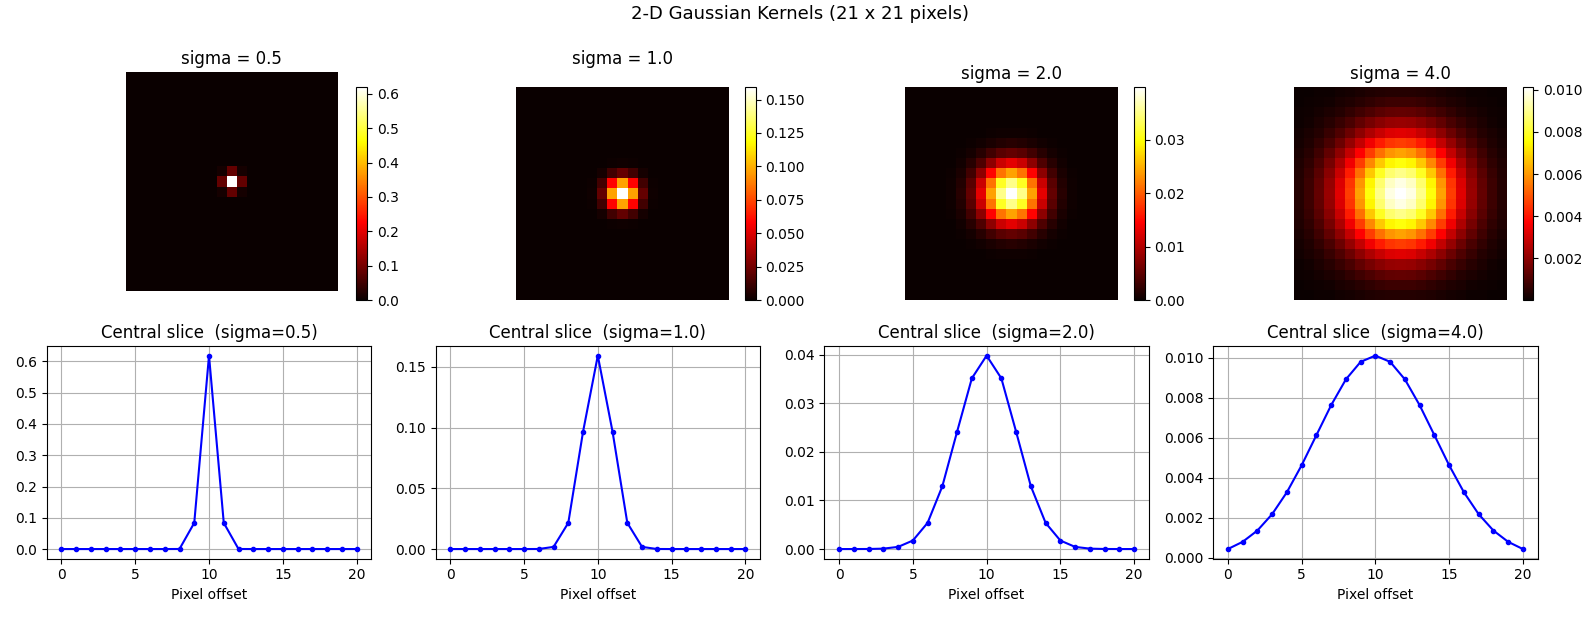

In [9]:
def gaussian_kernel_2d(size, sigma):
    """Build a normalised 2-D Gaussian kernel."""
    half = size // 2
    y, x = np.mgrid[-half : half + 1, -half : half + 1]
    kernel = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    return kernel / kernel.sum()

# Visualise how kernel shape changes with sigma
sigmas = [0.5, 1.0, 2.0, 4.0]
fig, axes = plt.subplots(2, 4, figsize=(16, 6))

for col, sigma in enumerate(sigmas):
    k = gaussian_kernel_2d(21, sigma)
    # 2-D heatmap
    im = axes[0, col].imshow(k, cmap='hot')
    axes[0, col].set_title(f'sigma = {sigma}')
    axes[0, col].axis('off')
    plt.colorbar(im, ax=axes[0, col], fraction=0.046)
    # Central cross-section
    axes[1, col].plot(k[10, :], 'b-o', markersize=3)
    axes[1, col].set_title(f'Central slice  (sigma={sigma})')
    axes[1, col].set_xlabel('Pixel offset')
    axes[1, col].grid(True)

plt.suptitle('2-D Gaussian Kernels (21 x 21 pixels)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

In [10]:
def plot_gaussian_blur(image_name='Scene', sigma=2.0):
    img     = TEST_IMAGES[image_name]
    blurred = ndimage.gaussian_filter(img, sigma=sigma)
    # Residual = what the blur removed (high-frequency detail)
    residual = img - blurred

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(blurred, cmap='gray', vmin=0, vmax=1)
    axes[1].set_title(f'Gaussian Blur  (sigma={sigma:.1f} px)')
    axes[1].axis('off')

    # Shift residual to [0,1] range for display
    axes[2].imshow(residual + 0.5, cmap='gray', vmin=0, vmax=1)
    axes[2].set_title(f'Residual = Original - Blurred\n(high-freq details removed, std={residual.std():.4f})')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()
    print(f'sigma={sigma:.1f}  |  residual std={residual.std():.4f}')

if WIDGETS_AVAILABLE:
    interact(
        plot_gaussian_blur,
        image_name=Dropdown(options=list(TEST_IMAGES.keys()), value='Scene', description='Image'),
        sigma=FloatSlider(min=0.1, max=20.0, step=0.1, value=2.0, description='Sigma (px)')
    )
else:
    plot_gaussian_blur(sigma=1.5)
    plot_gaussian_blur(sigma=6.0)

interactive(children=(Dropdown(description='Image', index=3, options=('Checkerboard', 'Concentric Rings', 'Sin…

### Frequency-domain vs. spatial-domain low-pass: they are equivalent

For intuition: the sharp circular frequency mask is a **box filter in frequency space**. The Gaussian kernel is a **smoother (Gaussian) mask in frequency space**. Both suppress high frequencies, but the Gaussian does it more gracefully — no Gibbs ringing artefacts.

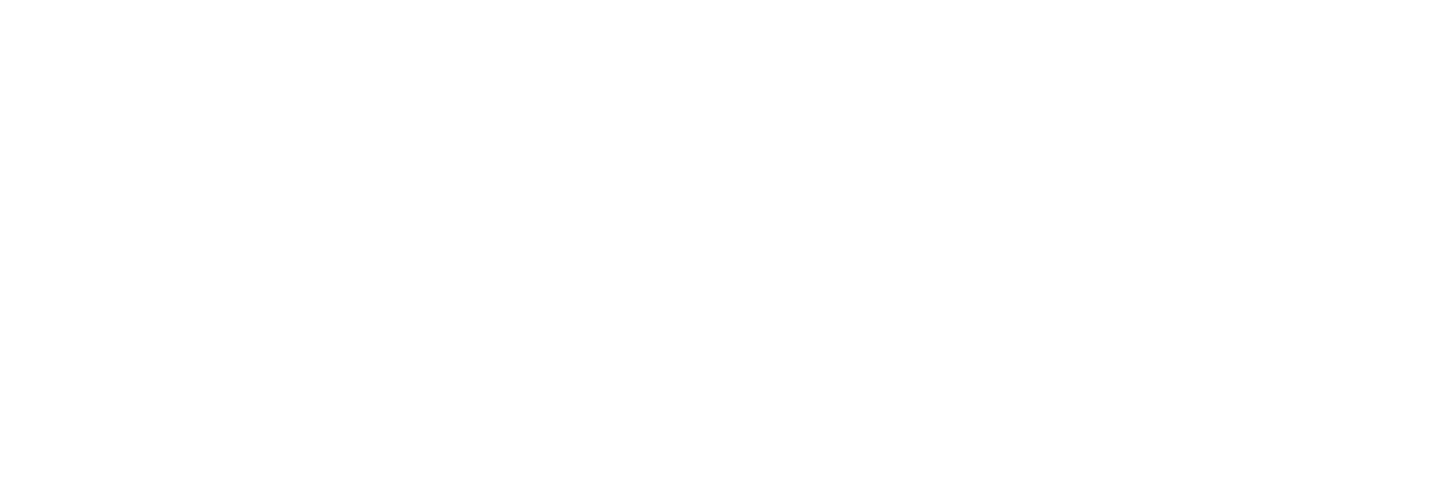

In [11]:
# Side-by-side comparison of the two low-pass approaches
img    = TEST_IMAGES['Scene']
gauss  = ndimage.gaussian_filter(img, sigma=4)
fft_lp, _, _ = frequency_filter(img, radius=20, filter_type='low-pass')
fft_lp = np.clip(fft_lp, 0, 1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img,   cmap='gray', vmin=0, vmax=1); axes[0].set_title('Original');                       axes[0].axis('off')
axes[1].imshow(gauss, cmap='gray', vmin=0, vmax=1); axes[1].set_title('Gaussian Blur (sigma=4)');         axes[1].axis('off')
axes[2].imshow(fft_lp, cmap='gray', vmin=0, vmax=1); axes[2].set_title('FFT Low-Pass (radius=20)');      axes[2].axis('off')
plt.suptitle('Two ways to blur — spot the ringing in the FFT version', fontsize=12)
plt.tight_layout()
plt.show()

## 5. Noise and Denoising

Real-world images are corrupted by various types of noise:

| Noise type | Cause | Characteristics |
|---|---|---|
| **Gaussian** | Sensor/thermal noise | Each pixel perturbed by $\mathcal{N}(0, \sigma^2)$ — smooth, additive |
| **Salt & Pepper** | Transmission errors / dead pixels | Random pixels set to 0 or 1 — impulsive |

Choice of denoising filter matters:
- **Gaussian filter** — effective against Gaussian noise; blurs edges
- **Median filter** — excellent against salt-and-pepper; better edge preservation
- **Uniform (mean) filter** — simple averaging; weaker than both above

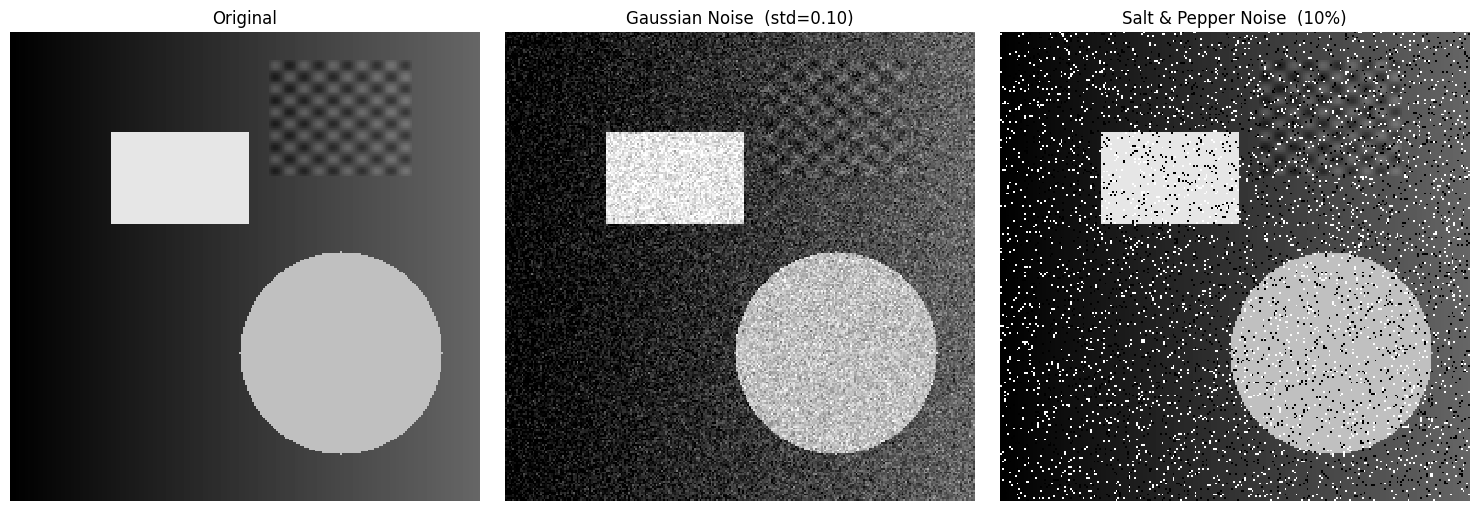

In [12]:
def add_gaussian_noise(image, std=0.08, seed=42):
    """Add zero-mean Gaussian (normal) noise."""
    rng = np.random.default_rng(seed)
    return np.clip(image + rng.normal(0, std, image.shape), 0, 1)

def add_salt_and_pepper(image, amount=0.05, seed=42):
    """Add impulse noise: random pixels become 0 (pepper) or 1 (salt)."""
    rng   = np.random.default_rng(seed)
    noisy = image.copy()
    n     = image.size
    salt  = rng.choice(n, int(n * amount / 2), replace=False)
    pepp  = rng.choice(n, int(n * amount / 2), replace=False)
    noisy.flat[salt] = 1.0
    noisy.flat[pepp] = 0.0
    return noisy

# Show both noise types
img  = TEST_IMAGES['Scene']
gn   = add_gaussian_noise(img, std=0.10)
spn  = add_salt_and_pepper(img, amount=0.10)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img, cmap='gray', vmin=0, vmax=1);  axes[0].set_title('Original');                          axes[0].axis('off')
axes[1].imshow(gn,  cmap='gray', vmin=0, vmax=1);  axes[1].set_title('Gaussian Noise  (std=0.10)');        axes[1].axis('off')
axes[2].imshow(spn, cmap='gray', vmin=0, vmax=1);  axes[2].set_title('Salt & Pepper Noise  (10%)');        axes[2].axis('off')
plt.tight_layout()
plt.show()

In [13]:
def plot_denoising(image_name='Scene',
                   noise_type='Gaussian', noise_level=0.10,
                   filter_name='Gaussian', filter_size=2.0):
    img = TEST_IMAGES[image_name]

    noisy = (add_gaussian_noise(img, std=noise_level)
             if noise_type == 'Gaussian'
             else add_salt_and_pepper(img, amount=noise_level))

    # Derive an odd kernel size from filter_size
    k = max(3, int(filter_size * 2 + 1))
    if k % 2 == 0:
        k += 1

    if filter_name == 'Gaussian':
        cleaned = ndimage.gaussian_filter(noisy, sigma=filter_size)
    elif filter_name == 'Median':
        cleaned = ndimage.median_filter(noisy, size=k)
    else:  # Uniform / Mean
        cleaned = ndimage.uniform_filter(noisy, size=k)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img,     cmap='gray', vmin=0, vmax=1); axes[0].set_title('Original');                          axes[0].axis('off')
    axes[1].imshow(noisy,   cmap='gray', vmin=0, vmax=1); axes[1].set_title(f'{noise_type} Noise  (level={noise_level:.2f})'); axes[1].axis('off')
    axes[2].imshow(cleaned, cmap='gray', vmin=0, vmax=1); axes[2].set_title(f'{filter_name} Filter  (size={filter_size:.1f})'); axes[2].axis('off')
    plt.tight_layout()
    plt.show()

    mse_n = np.mean((img - noisy)   ** 2)
    mse_c = np.mean((img - cleaned) ** 2)
    psnr  = lambda mse: -10 * np.log10(mse + 1e-12)
    print(f'  Noisy  MSE={mse_n:.5f}  PSNR={psnr(mse_n):.1f} dB')
    print(f'  Cleaned MSE={mse_c:.5f}  PSNR={psnr(mse_c):.1f} dB')
    print(f'  Noise reduction: {(1 - mse_c / mse_n) * 100:.1f}%')

if WIDGETS_AVAILABLE:
    interact(
        plot_denoising,
        image_name=Dropdown(options=list(TEST_IMAGES.keys()), value='Scene', description='Image'),
        noise_type=Dropdown(options=['Gaussian', 'Salt & Pepper'], description='Noise Type'),
        noise_level=FloatSlider(min=0.01, max=0.30, step=0.01, value=0.10, description='Noise Level'),
        filter_name=Dropdown(options=['Gaussian', 'Median', 'Uniform (Mean)'], description='Filter'),
        filter_size=FloatSlider(min=0.5, max=6.0, step=0.5, value=2.0, description='Filter Size')
    )
else:
    print('--- Gaussian noise + Gaussian filter ---')
    plot_denoising()
    print()
    print('--- Salt & Pepper noise + Median filter ---')
    plot_denoising(noise_type='Salt & Pepper', filter_name='Median')

interactive(children=(Dropdown(description='Image', index=3, options=('Checkerboard', 'Concentric Rings', 'Sin…

## 6. Edge Detection via Image Derivatives

An **edge** is where pixel intensity changes rapidly. We detect edges by computing image **gradients** — the discrete derivative of the intensity function.

### Gradient-based operators

We convolve the image with a small kernel that approximates the partial derivative:

$$G_x = \frac{\partial I}{\partial x} \approx K_x * I, \qquad G_y = \frac{\partial I}{\partial y} \approx K_y * I$$

The **gradient magnitude** combines both directions:
$$|\nabla I| = \sqrt{G_x^2 + G_y^2}$$

And the **gradient direction** gives the orientation of each edge:
$$\theta = \text{arctan2}(G_y, G_x)$$

### Operator kernels

| Operator | $K_x$ |
|---|---|
| **np.gradient** | Central-difference: $[-1, 0, 1]/2$ |
| **Sobel** | $[[-1,0,1],[-2,0,2],[-1,0,1]]$ (smoothing in Y, diff in X) |
| **Prewitt** | $[[-1,0,1],[-1,0,1],[-1,0,1]]$ (simpler smoothing) |
| **Laplacian** | $[[0,1,0],[1,-4,1],[0,1,0]]$ (second derivative — zero crossings = edges) |

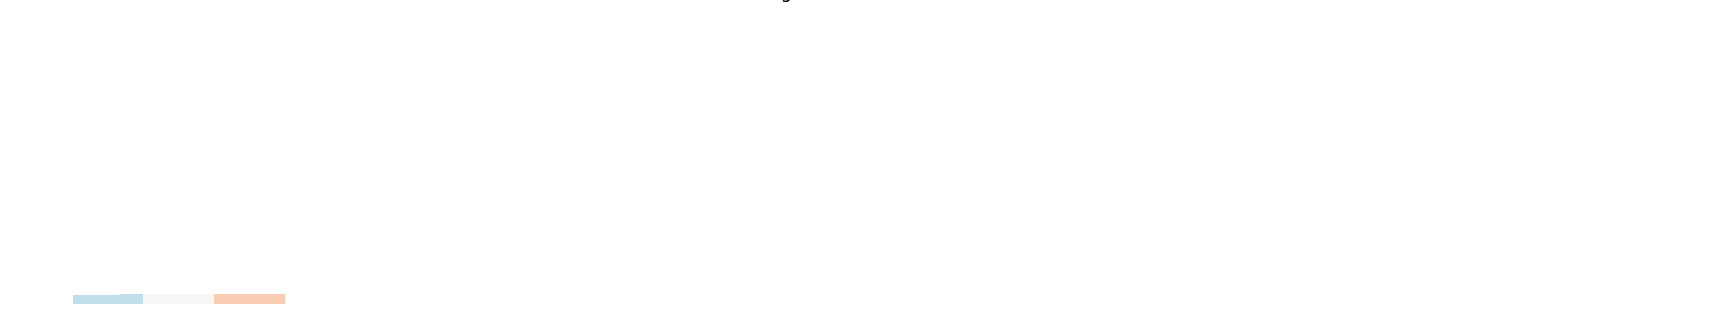

In [14]:
# Define the kernels
KERNELS = {
    'Sobel X':    np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=float),
    'Sobel Y':    np.array([[-1,-2,-1], [ 0, 0, 0], [ 1, 2, 1]], dtype=float),
    'Prewitt X':  np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=float),
    'Prewitt Y':  np.array([[-1,-1,-1], [ 0, 0, 0], [ 1, 1, 1]], dtype=float),
    'Laplacian':  np.array([[ 0, 1, 0], [ 1,-4, 1], [ 0, 1, 0]], dtype=float),
}

fig, axes = plt.subplots(1, 5, figsize=(18, 3))
for ax, (name, kernel) in zip(axes, KERNELS.items()):
    im = ax.imshow(kernel, cmap='RdBu_r', vmin=-4, vmax=4)
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            ax.text(j, i, f'{int(kernel[i, j])}', ha='center', va='center',
                    fontsize=14, fontweight='bold', color='white' if abs(kernel[i,j]) >= 2 else 'black')
    ax.set_title(name, fontsize=10)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046)

plt.suptitle('Edge Detection Kernels', fontsize=13, y=1.05)
plt.tight_layout()
plt.show()

In [15]:
def compute_edges(image, method='Sobel', pre_blur=0.0):
    """Return (Gx, Gy, magnitude, direction) or (response, None, |response|, None) for Laplacian."""
    if pre_blur > 0:
        image = ndimage.gaussian_filter(image, sigma=pre_blur)

    if method == 'np.gradient':
        gy, gx = np.gradient(image)  # np.gradient returns (dy, dx)
    elif method in ('Sobel', 'Prewitt'):
        gx = ndimage.convolve(image, KERNELS[f'{method} X'])
        gy = ndimage.convolve(image, KERNELS[f'{method} Y'])
    elif method == 'Laplacian':
        resp = ndimage.convolve(image, KERNELS['Laplacian'])
        return resp, None, np.abs(resp), None

    magnitude  = np.sqrt(gx ** 2 + gy ** 2)
    direction  = np.arctan2(gy, gx)
    return gx, gy, magnitude, direction


def plot_edge_detection(image_name='Scene', method='Sobel',
                        pre_blur=0.0, threshold=0.10):
    img = TEST_IMAGES[image_name]
    gx, gy, magnitude, direction = compute_edges(img, method, pre_blur)
    edges = magnitude > threshold * magnitude.max()

    if method == 'Laplacian':
        fig, axes = plt.subplots(1, 4, figsize=(18, 4))
        axes[0].imshow(img,       cmap='gray',   vmin=0, vmax=1); axes[0].set_title('Original');             axes[0].axis('off')
        axes[1].imshow(gx,        cmap='RdBu_r');                  axes[1].set_title('Laplacian Response');   axes[1].axis('off')
        axes[2].imshow(magnitude, cmap='hot');                     axes[2].set_title('|Laplacian|');          axes[2].axis('off')
        axes[3].imshow(edges,     cmap='gray');                    axes[3].set_title(f'Edges  (thr={threshold:.2f})'); axes[3].axis('off')
    else:
        fig, axes = plt.subplots(1, 5, figsize=(22, 4))
        axes[0].imshow(img,       cmap='gray',   vmin=0, vmax=1); axes[0].set_title('Original');                      axes[0].axis('off')
        axes[1].imshow(gx,        cmap='RdBu_r');                  axes[1].set_title(r'Gx  ($\partial I/\partial x$)' + '\nhorizontal edges'); axes[1].axis('off')
        axes[2].imshow(gy,        cmap='RdBu_r');                  axes[2].set_title(r'Gy  ($\partial I/\partial y$)' + '\nvertical edges');   axes[2].axis('off')
        axes[3].imshow(magnitude, cmap='hot');                     axes[3].set_title(r'Magnitude $|\nabla I|$' + '\n= sqrt(Gx²+Gy²)');        axes[3].axis('off')
        axes[4].imshow(edges,     cmap='gray');                    axes[4].set_title(f'Edges  (thr={threshold:.2f})');                         axes[4].axis('off')

    blur_str = f'  pre-blur σ={pre_blur}' if pre_blur > 0 else ''
    plt.suptitle(f'{method} Edge Detection{blur_str}', fontsize=12)
    plt.tight_layout()
    plt.show()
    n = edges.sum()
    print(f'  Edge pixels: {n}  ({n / img.size * 100:.1f}% of image)')


if WIDGETS_AVAILABLE:
    interact(
        plot_edge_detection,
        image_name=Dropdown(options=list(TEST_IMAGES.keys()), value='Scene', description='Image'),
        method=Dropdown(options=['np.gradient', 'Sobel', 'Prewitt', 'Laplacian'], description='Method'),
        pre_blur=FloatSlider(min=0, max=4.0, step=0.25, value=0.0, description='Pre-blur σ'),
        threshold=FloatSlider(min=0.01, max=0.5, step=0.01, value=0.10, description='Threshold')
    )
else:
    print('--- Sobel (no pre-blur) ---')
    plot_edge_detection()
    print()
    print('--- Sobel with pre-blur (noise-robust) ---')
    plot_edge_detection(pre_blur=1.0, threshold=0.12)

interactive(children=(Dropdown(description='Image', index=3, options=('Checkerboard', 'Concentric Rings', 'Sin…

### Edge direction visualisation

The gradient direction $\theta = \text{arctan2}(G_y, G_x)$ is perpendicular to the edge. Colouring by direction reveals the orientation structure of all edges in the image.

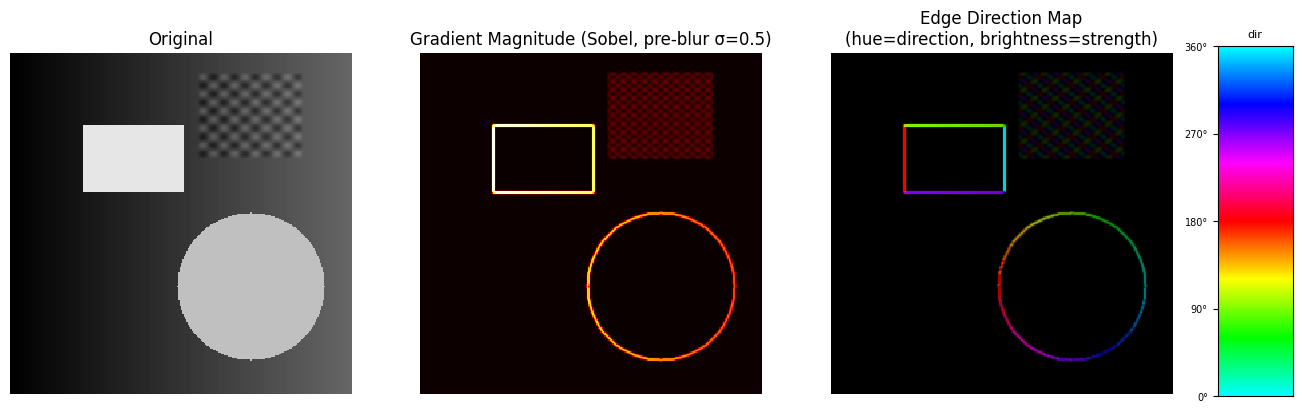

In [18]:
img = TEST_IMAGES['Scene']
gx, gy, magnitude, direction = compute_edges(img, method='Sobel', pre_blur=0.5)

# Create an HSV-coded edge map: hue=direction, value=magnitude (normalised)
import matplotlib.colors as mcolors
h = (direction / (2 * np.pi) + 0.5) % 1.0      # direction → [0, 1]
s = np.ones_like(h)
v = np.clip(magnitude / magnitude.max(), 0, 1)  # brightness by strength
hsv_img = np.dstack([h, s, v])
rgb_img = mcolors.hsv_to_rgb(hsv_img)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img,       cmap='gray', vmin=0, vmax=1); axes[0].set_title('Original');                              axes[0].axis('off')
axes[1].imshow(magnitude, cmap='hot');                  axes[1].set_title('Gradient Magnitude (Sobel, pre-blur σ=0.5)'); axes[1].axis('off')
axes[2].imshow(rgb_img);                                axes[2].set_title('Edge Direction Map\n(hue=direction, brightness=strength)'); axes[2].axis('off')

# Colour wheel legend
ax_cw = fig.add_axes([0.93, 0.15, 0.05, 0.7])
angles = np.linspace(0, 2 * np.pi, 360)
wheel_h = (angles / (2 * np.pi) + 0.5) % 1.0
wheel   = mcolors.hsv_to_rgb(np.dstack([wheel_h[:, np.newaxis], np.ones((360, 1)), np.ones((360, 1))]))
ax_cw.imshow(wheel, aspect='auto', extent=[0, 1, 0, 360])
ax_cw.set_yticks([0, 90, 180, 270, 360])
ax_cw.set_yticklabels(['0°', '90°', '180°', '270°', '360°'], fontsize=7)
ax_cw.set_xticks([])
ax_cw.set_title('dir', fontsize=8)

plt.show()

## 7. Complete Processing Pipeline

Putting it all together: a typical image-processing pipeline is:

```
Original → [add noise] → [denoise/blur] → [edge detection] → detected edges
```

The blur step before edge detection is crucial: it suppresses noise that would otherwise create spurious edges.

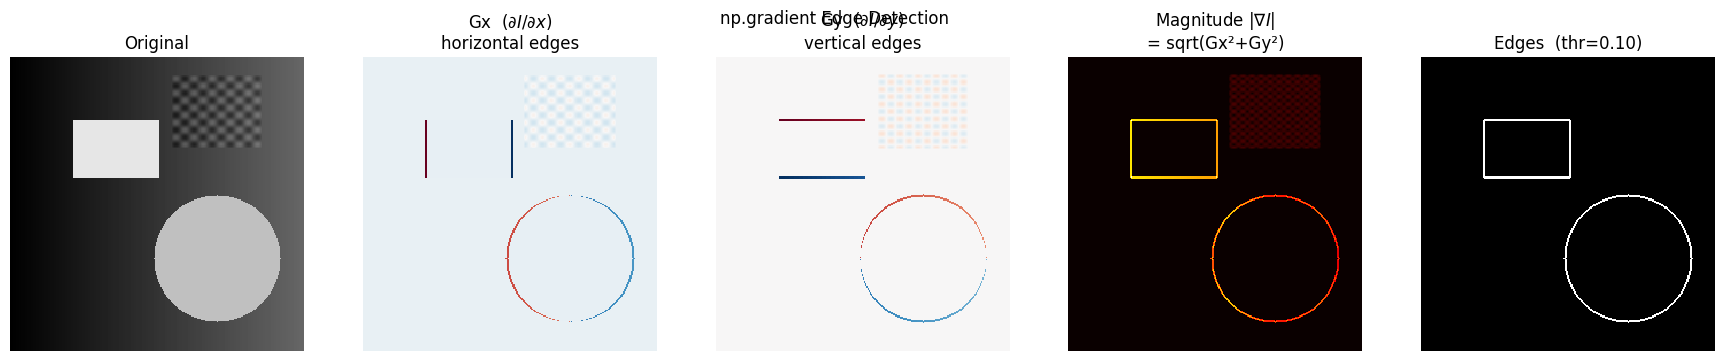

Edge pixels from noisy image:    15872
Edge pixels after denoising:      5477
Pre-smoothing greatly reduces false edges caused by noise.


In [17]:
img      = TEST_IMAGES['Scene']
noisy    = add_gaussian_noise(img,   std=0.08)
denoised = ndimage.gaussian_filter(noisy, sigma=1.5)

_, _, edges_from_noisy,    _ = compute_edges(noisy,    method='Sobel')
_, _, edges_from_denoised, _ = compute_edges(denoised, method='Sobel')

thr = 0.12
bin_noisy    = edges_from_noisy    > thr * edges_from_noisy.max()
bin_denoised = edges_from_denoised > thr * edges_from_denoised.max()

stages  = [img,   noisy,   denoised,   edges_from_noisy, bin_noisy,    bin_denoised]
titles  = ['Original', 'Noisy\n(Gaussian σ=0.08)', 'Denoised\n(Gaussian σ=1.5)',
           'Edge Magnitude\n(from noisy)', 'Edges from noisy', 'Edges from denoised']
cmaps   = ['gray', 'gray', 'gray', 'hot', 'gray', 'gray']

fig, axes = plt.subplots(1, 6, figsize=(26, 4))
for ax, stage, title, cmap in zip(axes, stages, titles, cmaps):
    ax.imshow(stage, cmap=cmap)
    ax.set_title(title, fontsize=9)
    ax.axis('off')

plt.suptitle('Full Pipeline: Original → Noisy → Denoise → Edge Detection', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

print(f'Edge pixels from noisy image:    {bin_noisy.sum():5d}')
print(f'Edge pixels after denoising:     {bin_denoised.sum():5d}')
print('Pre-smoothing greatly reduces false edges caused by noise.')

## Summary

| Technique | Key API | Idea |
|---|---|---|
| 2-D FFT | `np.fft.fft2`, `fftshift` | Decomposes image into spatial frequencies |
| Freq-domain low-pass | `fft2` + circular mask + `ifft2` | Keep low freqs → blur |
| Freq-domain high-pass | `fft2` + inverted mask + `ifft2` | Keep high freqs → edges |
| Gaussian blur | `scipy.ndimage.gaussian_filter` | Convolution with Gaussian kernel = spatial low-pass |
| Gaussian noise | `np.random.default_rng().normal` | Additive; Gaussian filter removes it well |
| Salt & Pepper noise | Random pixel replacement | Impulse; Median filter removes it well |
| Gaussian denoising | `scipy.ndimage.gaussian_filter` | Smooth noise, trade off against edge blur |
| Median denoising | `scipy.ndimage.median_filter` | Non-linear; removes impulse noise without blurring edges |
| Gradient (NumPy) | `np.gradient` | Finite-difference derivative |
| Sobel / Prewitt | `scipy.ndimage.convolve` + 3×3 kernels | Smoothed first-derivative edge operators |
| Laplacian | `scipy.ndimage.convolve` + Laplacian kernel | Second derivative — zero-crossings = edges |

### Key takeaways
1. **FFT links blur and convolution**: Gaussian blur (spatial) ≡ Gaussian mask in frequency space — but the sharp circular mask produces Gibbs ringing that the Gaussian avoids.
2. **Filter choice matters**: Median filter beats Gaussian for impulse noise; Gaussian beats Median for Gaussian noise.
3. **Always pre-blur before edge detection** when the image is noisy — it suppresses false edges from noise while preserving true structural edges.
4. **Sobel > Prewitt > `np.gradient`** in noise robustness: Sobel weights the centre row/column more heavily, acting as a mild smoother.